# Modules

In [55]:
%load_ext autoreload
%autoreload 2

import sys

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
import torch
from sklearn import datasets, preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.manifold import TSNE
from sklearn.metrics import (ConfusionMatrixDisplay, classification_report, confusion_matrix)
from sklearn.model_selection import train_test_split

from torch.optim import Adam
from torch.utils.data import DataLoader

from tqdm.autonotebook import tqdm

from models.model import Neural_Net
from dataset_samplers import RandomCorruptSampler, ClassCorruptSampler, SupervisedSampler 
from training import train_contrastive_loss_epoch, train_classification_epoch
from utils import fix_seed, load_openml_list, preprocess_datasets, fit_one_hot_encoder


seed = 1234
fix_seed(seed)

clf = LogisticRegression()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Using device: cuda


# Data

In [56]:
# Toy dataset
# dataset_name = 'breast_cancer'
# data = datasets.load_breast_cancer(as_frame=True)
# data, target = data["data"], data["target"]

# OpenML dataset
datasets = load_openml_list([6, 6332])
# select one dataset to run below
dataset = datasets[1]
dataset_name, data, target = dataset
print(f"Loaded dataset: {dataset_name}, with data shape: {data.shape}, and target shape: {target.shape}")

Loading letter 6 ..
Loading cylinder-bands 6332 ..


/home/wei/anaconda3/envs/pfgen/lib/python3.9/site-packages/openml/datasets/functions.py:438: FutureWarning: Starting from Version 0.15 `download_data`, `download_qualities`, and `download_features_meta_data` will all be ``False`` instead of ``True`` by default to enable lazy loading. To disable this message until version 0.15 explicitly set `download_data`, `download_qualities`, and `download_features_meta_data` to a bool while calling `get_dataset`.
  warnings.warn(
/home/wei/anaconda3/envs/pfgen/lib/python3.9/site-packages/openml/datasets/functions.py:438: FutureWarning: Starting from Version 0.15 `download_data`, `download_qualities`, and `download_features_meta_data` will all be ``False`` instead of ``True`` by default to enable lazy loading. To disable this message until version 0.15 explicitly set `download_data`, `download_qualities`, and `download_features_meta_data` to a bool while calling `get_dataset`.
  warnings.warn(


Loaded dataset: cylinder-bands, with data shape: (540, 37), and target shape: (540,)


In [57]:
tmp_data, test_data, tmp_target, test_target = train_test_split(
    data, 
    target, 
    test_size=0.2, 
    stratify=target, 
    random_state=seed
)

train_data, valid_data, train_target, valid_target = train_test_split(
    tmp_data,
    tmp_target,
    test_size=1/7,
    stratify=tmp_target,
    random_state=seed
)

print(f"# samples: Train: {len(train_data)}; Valid: {len(valid_data)}; Test: {len(test_data)}")
print(f"Train data with type {type(train_data)} and shape {train_data.shape}; Train target with type: {type(train_target)} and shape {train_target.shape}")
print(f"Valid data with type {type(valid_data)} and shape {valid_data.shape}; Valid target with type: {type(valid_target)} and shape {valid_target.shape}")
print(f"Test data with type {type(test_data)} and shape {test_data.shape}; Test target with type: {type(test_target)} and shape {test_target.shape}")

# ensure the splits lead to no class mismatch
assert np.all(np.unique(train_target).sort() == np.unique(valid_target).sort()) and \
        np.all(np.unique(train_target).sort() == np.unique(test_target).sort())
n_classes = len(np.unique(train_target))

print(f"The dataset has {n_classes} classes: {np.unique(train_target)}")


# samples: Train: 370; Valid: 62; Test: 108
Train data with type <class 'pandas.core.frame.DataFrame'> and shape (370, 37); Train target with type: <class 'pandas.core.series.Series'> and shape (370,)
Valid data with type <class 'pandas.core.frame.DataFrame'> and shape (62, 37); Valid target with type: <class 'pandas.core.series.Series'> and shape (62,)
Test data with type <class 'pandas.core.frame.DataFrame'> and shape (108, 37); Test target with type: <class 'pandas.core.series.Series'> and shape (108,)
The dataset has 2 classes: ['band' 'noband']


In [58]:
preprocess_datasets(train_data, valid_data, test_data, normalize_numerical_features=True)
one_hot_encoder = fit_one_hot_encoder(preprocessing.OneHotEncoder(handle_unknown='ignore', drop='if_binary', sparse_output=False), train_data)

# encode targets with label encoding (later will be one-hot encoded in the neural network)
# from here, use the label encoded targets instead of the original potentially string values
print("Original training targets: ", train_target, "with shape: ", train_target.shape)

label_encoder_target = preprocessing.LabelEncoder()
train_target = label_encoder_target.fit_transform(train_target)
valid_target = label_encoder_target.transform(valid_target)
test_target = label_encoder_target.transform(test_target)

print("One-hot encoded targets: ", train_target, "with shape: ", np.shape(train_target), "and max value: ", np.max(train_target), f"({n_classes} classes)")

Data preprocess finished! Dropped 3 features: ['ink_color', 'blade_mfg', 'cylinder_division']. Normalized numerical features.
Original training targets:  535      band
145    noband
212    noband
381    noband
198    noband
        ...  
225    noband
450    noband
197      band
521      band
370    noband
Name: band_type, Length: 370, dtype: category
Categories (2, object): ['band' < 'noband'] with shape:  (370,)
One-hot encoded targets:  [0 1 1 1 1 0 1 1 0 1 1 0 0 0 1 0 0 0 1 0 1 1 1 1 0 0 1 0 1 1 0 1 0 0 0 1 0
 0 1 0 1 1 0 0 1 1 0 1 0 1 0 0 0 0 0 0 1 1 1 1 1 0 0 0 1 0 1 1 0 1 0 1 1 1
 0 1 1 1 1 0 0 1 0 0 1 1 0 1 1 1 1 0 1 0 1 0 1 1 1 1 1 0 1 0 0 0 1 1 1 0 1
 1 0 0 0 1 0 1 1 1 0 1 1 1 1 0 0 1 1 0 1 0 0 0 1 1 1 0 1 1 1 1 0 0 0 1 1 1
 1 0 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 1 1 0 1 1 1 1 0 0 0 1 0 1 0 1 1 1 0 1 0
 0 1 1 1 0 0 1 1 1 1 1 0 0 1 0 0 0 0 0 1 1 0 1 0 0 1 1 1 0 0 0 1 1 1 0 0 1
 1 1 1 1 0 0 1 1 1 1 0 0 0 1 1 0 0 1 1 0 1 1 0 1 1 1 0 1 1 1 1 1 1 0 1 1 1
 1 0 0 1 0 0 0 0 1 0 1 1 1 1 0 

In [59]:
fraction_withLabel = 0.25
n_train_samples_labeled = int(len(train_data)*fraction_withLabel)
# shouldn't index using this variable as it shuffles the ordering
idxes_tmp = np.random.permutation(len(train_data))[:n_train_samples_labeled]
mask_train_labeled = np.zeros(len(train_data), dtype=bool)
mask_train_labeled[idxes_tmp] = True

print(f"Under semi-supervised learning, assume {n_train_samples_labeled}/{len(train_data)} training samples are labeled.")

Under semi-supervised learning, assume 92/370 training samples are labeled.


In [61]:
batch_size = 128

train_data_samplers = {}

# Random Sampling
train_data_samplers['rand_corr'] = RandomCorruptSampler(train_data, batch_size) # not using class information in original corruption

# Oracle Class Sampling
train_data_samplers['orc_corr'] = ClassCorruptSampler(train_data, batch_size, train_target) # oracle info on training labels

# Predicted Class Sampling
# Use a fraction of labeled samples
print("Using a simple logistic regression to fit to the labeled set for pseudo labeling...")
# sklearn logistic regression implementation takes in raw single-value target
clf.fit(one_hot_encoder.transform(train_data)[mask_train_labeled], train_target[mask_train_labeled])
train_predictions = clf.predict(one_hot_encoder.transform(train_data))

train_data_samplers['cls_corr'] = ClassCorruptSampler(train_data, batch_size, \
    np.where(mask_train_labeled, train_target, train_predictions) # bootstrapped training labels
)

Using a simple logistic regression to fit to the labeled set for pseudo labeling...


In [62]:
models, optimizers, loss_histories = {}, {}, {}
for key in ['orig_input', 'rand_corr', 'cls_corr', 'orc_corr']:
    models[key] = Neural_Net(
        input_dim=one_hot_encoder.transform(train_data).shape[1],  # model expect one-hot encoded input
        emb_dim=256,
        output_dim=n_classes,
        model_device=device    
    ).to(device)
    optimizers[key] = Adam(models[key].parameters(), lr=0.001)
    loss_histories[key] = []

Created a model with input dimension: 146, embedding dimension 256, and output dimension 2!
Created a model with input dimension: 146, embedding dimension 256, and output dimension 2!
Created a model with input dimension: 146, embedding dimension 256, and output dimension 2!
Created a model with input dimension: 146, embedding dimension 256, and output dimension 2!


# Training

In [63]:
epochs = 3_000

for epoch in tqdm(range(1, epochs + 1)):
    for key in ['rand_corr', 'cls_corr', 'orc_corr']:
        epoch_loss = train_contrastive_loss_epoch(models[key], train_data_samplers[key], optimizers[key], one_hot_encoder, device)
        loss_histories[key].append(epoch_loss)

# save the models and losses
for key in ['rand_corr', 'cls_corr', 'orc_corr']:
    model_filename = f'trained_models/{dataset_name}_{key}.pt'
    torch.save(models[key].state_dict(), model_filename)
    print(f"Model saved at {model_filename}!")
    loss_filename = f"trained_models/{dataset_name}_{key}_contrastive_losses.npy"
    np.save(loss_filename, loss_histories[key])
    print(f"Model losses saved at {loss_filename}!")

100%|██████████| 3000/3000 [16:09<00:00,  3.10it/s]

Model saved at trained_models/cylinder-bands_rand_corr.pt!
Model losses saved at trained_models/cylinder-bands_rand_corr_contrastive_losses.npy!
Model saved at trained_models/cylinder-bands_cls_corr.pt!
Model losses saved at trained_models/cylinder-bands_cls_corr_contrastive_losses.npy!
Model saved at trained_models/cylinder-bands_orc_corr.pt!
Model losses saved at trained_models/cylinder-bands_orc_corr_contrastive_losses.npy!


# [Optional] Load previously trained models and their losses

In [40]:
for key in ['rand_corr', 'cls_corr', 'orc_corr']:
    model_filename = f'trained_models/{dataset_name}_{key}.pt'
    models[key].load_state_dict(torch.load(model_filename))
    print(f"Model loaded from {model_filename}!")
    loss_filename = f"trained_models/{dataset_name}_{key}_contrastive_losses.npy"
    loss_histories[key] = np.load(loss_filename)
    print(f"Model losses loaded from {loss_filename}!")

Model loaded from trained_models/breast_cancer_rand_corr.pt!
Model losses loaded from trained_models/breast_cancer_rand_corr_losses.npy!
Model loaded from trained_models/breast_cancer_cls_corr.pt!
Model losses loaded from trained_models/breast_cancer_cls_corr_losses.npy!
Model loaded from trained_models/breast_cancer_orc_corr.pt!
Model losses loaded from trained_models/breast_cancer_orc_corr_losses.npy!


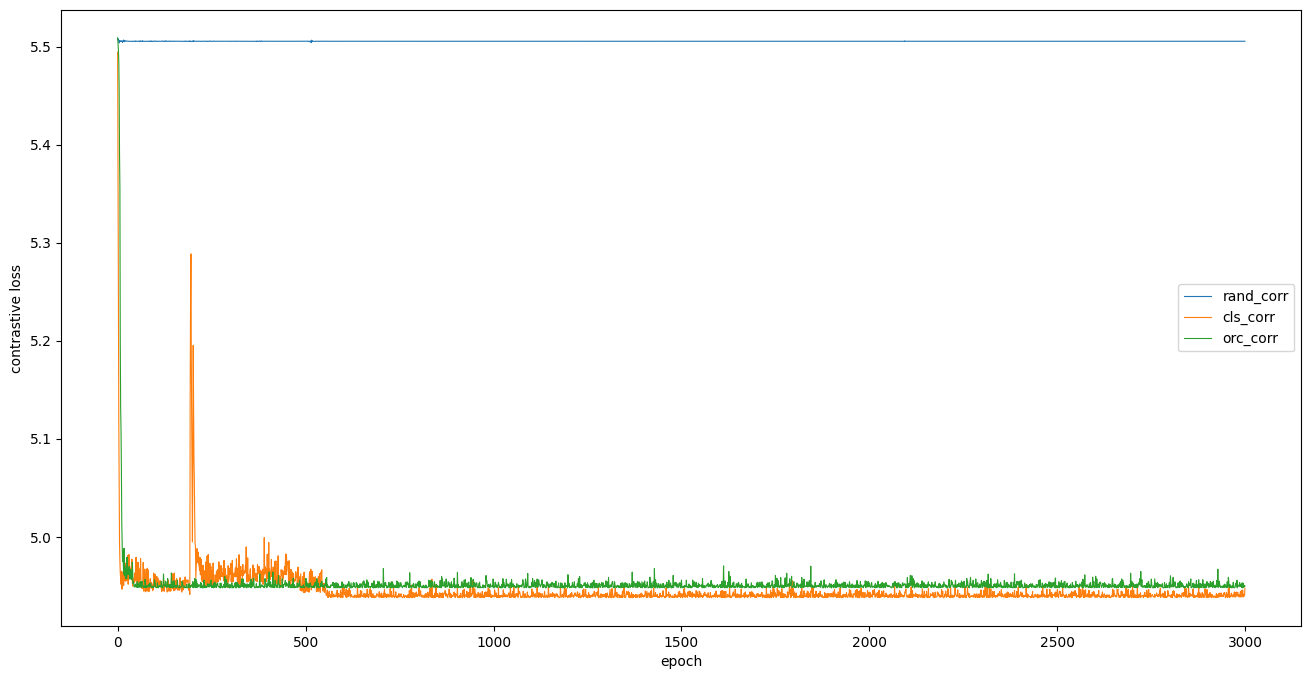

In [64]:
fig, ax = plt.subplots(figsize=(16, 8))
for key in ['rand_corr', 'cls_corr', 'orc_corr']:
    ax.plot(loss_histories[key], label=key, linewidth=0.8)
ax.set_xlabel("epoch")
ax.set_ylabel("contrastive loss")
ax.legend()

# Tuning on down-stream task

100%|██████████| 1000/1000 [00:32<00:00, 30.62it/s]


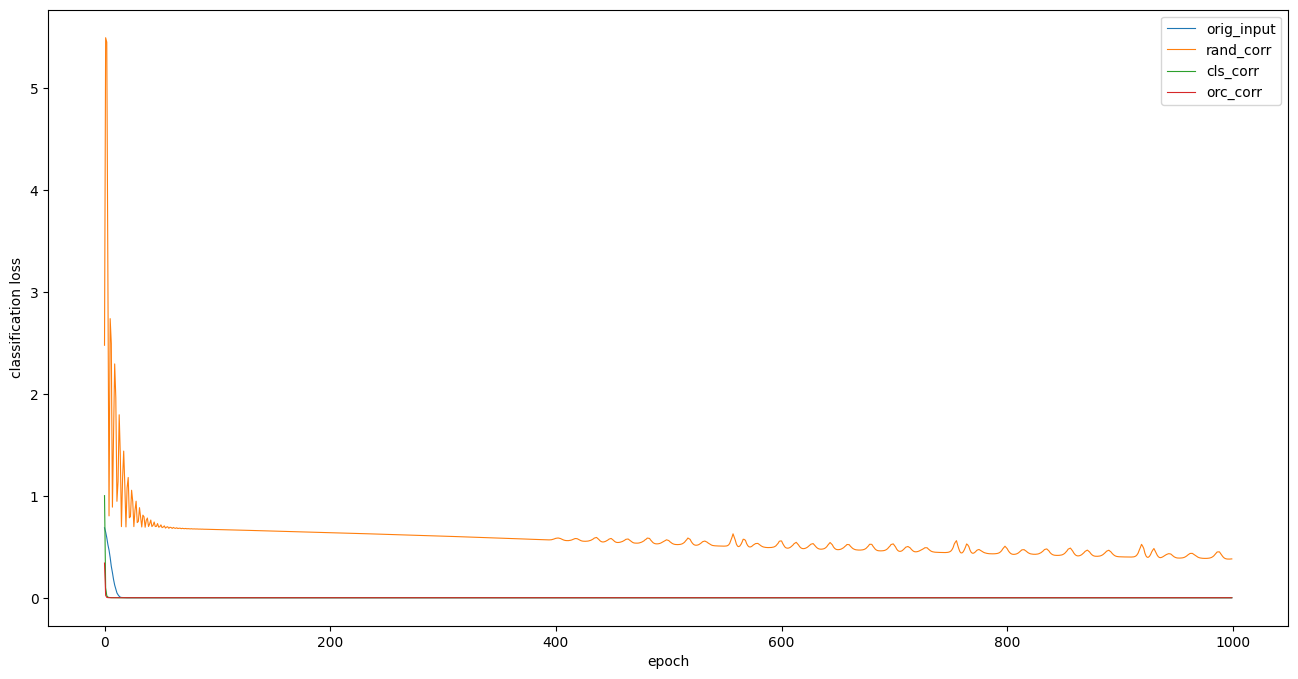

In [70]:
epochs = 1_000

# Take the labeled dataset
# For now, just use a single sampler, would lead to different shuffled order for training data to different models, shouldn't be any essential difference
supervised_sampler = SupervisedSampler(data=train_data[mask_train_labeled], batch_size=batch_size, target=train_target[mask_train_labeled])

for key in ['rand_corr', 'cls_corr', 'orc_corr']:
    models[key].freeze_encoder()

optimizers, loss_histories = {}, {}
for key in ['orig_input', 'rand_corr', 'cls_corr', 'orc_corr']:
    optimizers[key] = Adam(filter(lambda p: p.requires_grad, models[key].parameters()), lr=0.001)
    loss_histories[key] = []

for eopch in tqdm(range(1, epochs+1)):
    for key in ['orig_input', 'rand_corr', 'cls_corr', 'orc_corr']:
        epoch_loss = train_classification_epoch(models[key], supervised_sampler, optimizers[key], one_hot_encoder, device)
        loss_histories[key].append(epoch_loss)

# visualize loss
fig, ax = plt.subplots(figsize=(16, 8))
for key in ['orig_input', 'rand_corr', 'cls_corr', 'orc_corr']:
    ax.plot(loss_histories[key], label=key, linewidth=0.8)
ax.set_xlabel("epoch")
ax.set_ylabel("classification loss")
ax.legend()

In [72]:
# Test the trained classification models
for key in ['orig_input', 'rand_corr', 'cls_corr', 'orc_corr']:
    models[key].eval()
    with torch.no_grad():
        test_predictions_tmp = models[key].get_classification_predictions(torch.tensor(one_hot_encoder.transform(test_data), dtype=torch.float32).to(device)).cpu().numpy()
        test_predictions = np.argmax(test_predictions_tmp,axis=1)
        print(f"{key} Classification report:")
        print(classification_report(test_target, test_predictions))
        print("Classification accuracy: {:.3f} %".format(np.mean(test_predictions==test_target)*100))


orig_input Classification report:
              precision    recall  f1-score   support

           0       0.62      0.46      0.52        46
           1       0.66      0.79      0.72        62

    accuracy                           0.65       108
   macro avg       0.64      0.62      0.62       108
weighted avg       0.64      0.65      0.64       108

Classification accuracy: 64.815 %
rand_corr Classification report:
              precision    recall  f1-score   support

           0       0.56      0.63      0.59        46
           1       0.70      0.63      0.66        62

    accuracy                           0.63       108
   macro avg       0.63      0.63      0.63       108
weighted avg       0.64      0.63      0.63       108

Classification accuracy: 62.963 %
cls_corr Classification report:
              precision    recall  f1-score   support

           0       0.59      0.59      0.59        46
           1       0.69      0.69      0.69        62

    accuracy   

/home/wei/anaconda3/envs/pfgen/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 13, 14] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/wei/anaconda3/envs/pfgen/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 13, 14] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/wei/anaconda3/envs/pfgen/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 13, 14] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/wei/anaconda3/envs/pfgen/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 13, 14] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


# Visualize embeddings

In [73]:
# get embeddings for training and test set
train_embeddings, test_embeddings = {}, {}
for key in ['rand_corr', 'cls_corr', 'orc_corr']:
    models[key].eval()
    with torch.no_grad():
        train_embeddings[key] = models[key].get_middle_embedding(torch.tensor(one_hot_encoder.transform(train_data), dtype=torch.float32).to(device)).cpu().numpy()
        test_embeddings[key] = models[key].get_middle_embedding(torch.tensor(one_hot_encoder.transform(test_data), dtype=torch.float32).to(device)).cpu().numpy()

/home/wei/anaconda3/envs/pfgen/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 13, 14] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/wei/anaconda3/envs/pfgen/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 13, 14] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/wei/anaconda3/envs/pfgen/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 13, 14] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


# Visualzie using t-sne 

/home/wei/anaconda3/envs/pfgen/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 13, 14] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/wei/anaconda3/envs/pfgen/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 13, 14] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


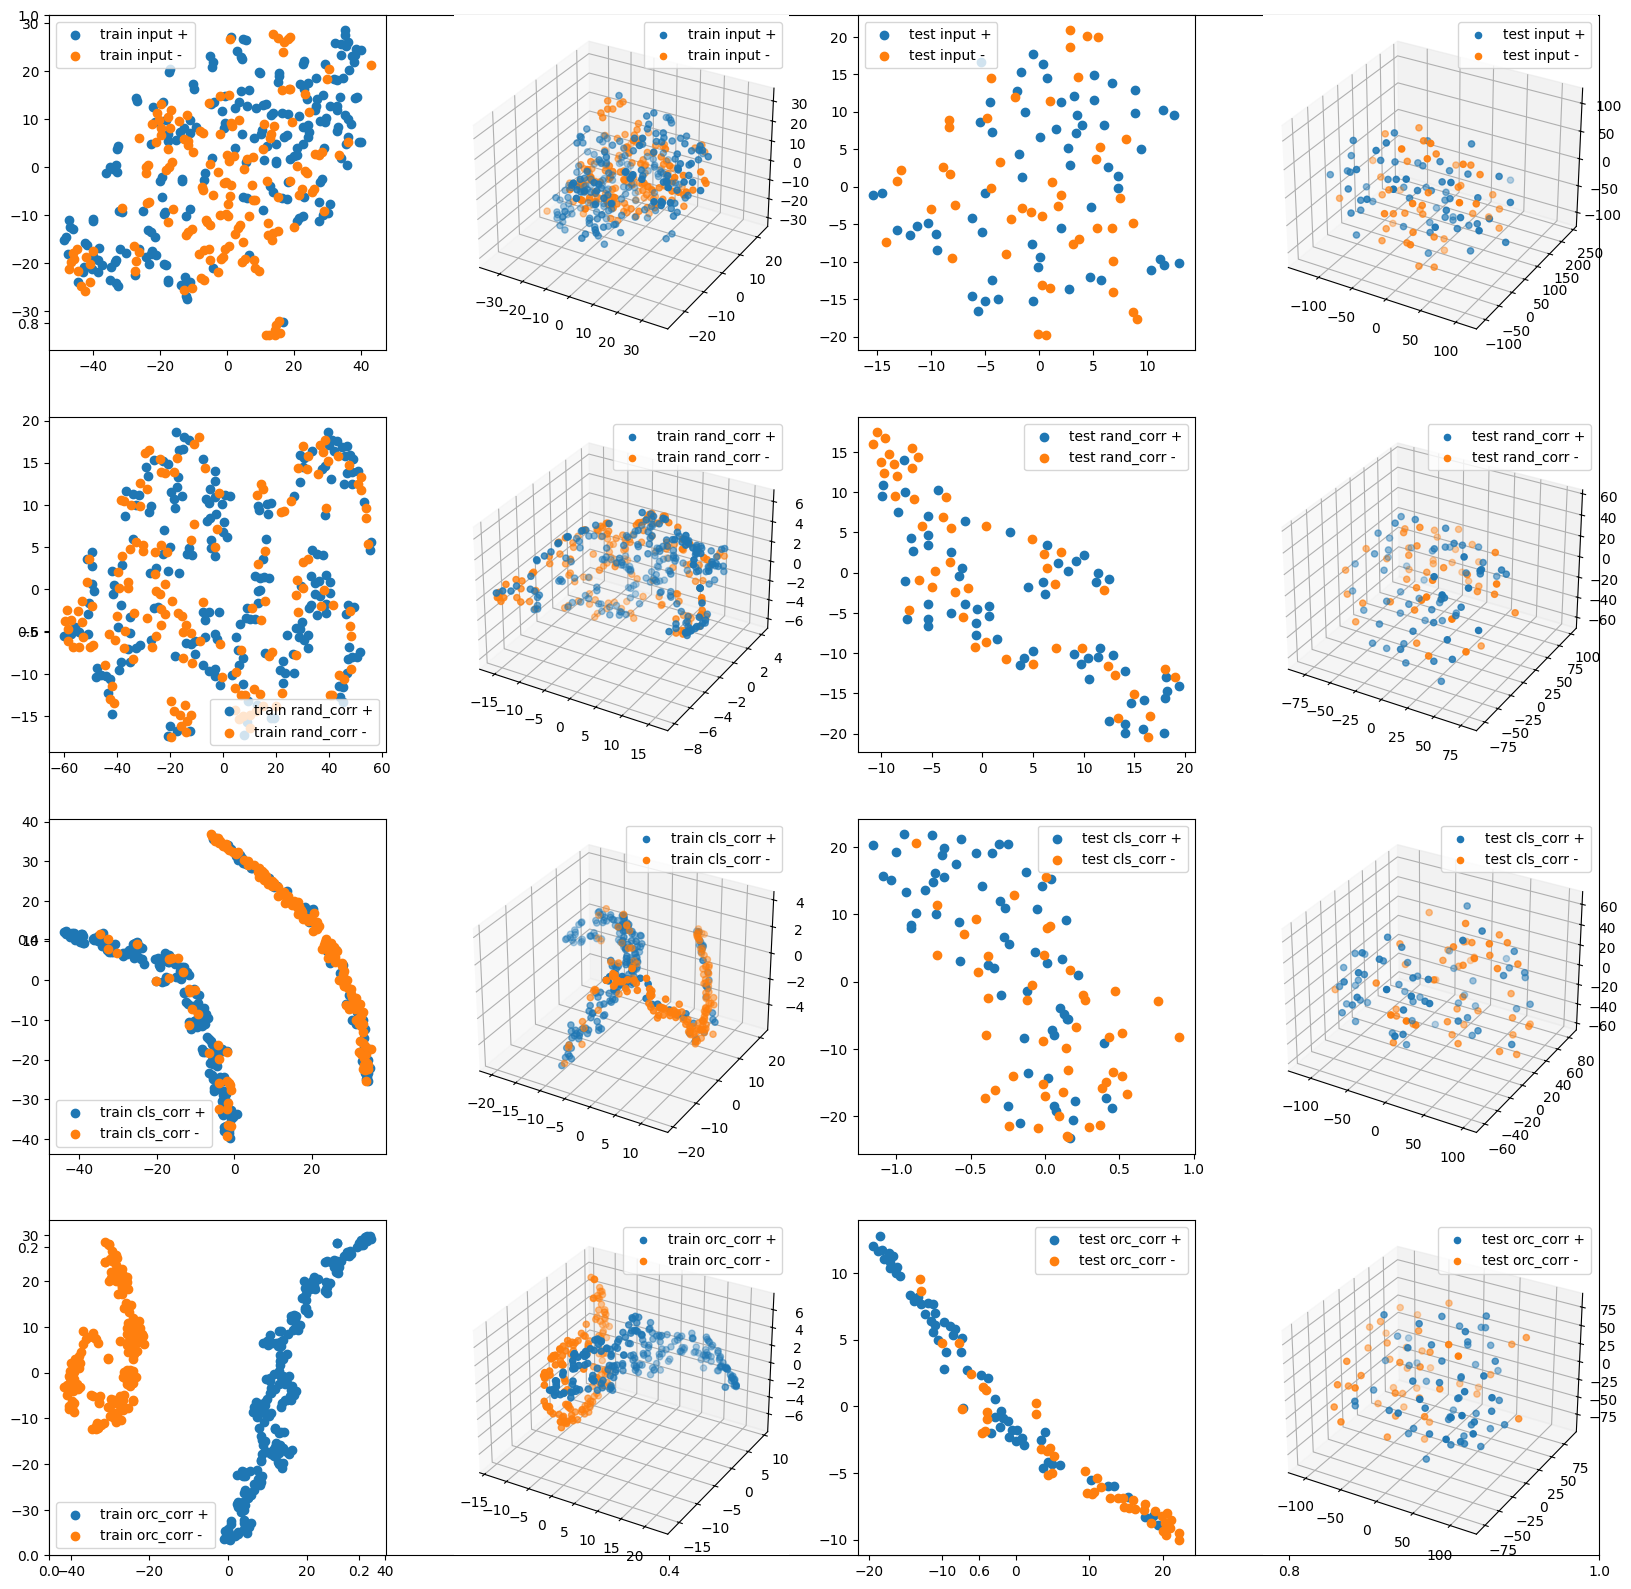

In [74]:
# visualize in 2D
fig, axes = plt.subplots(figsize=(20, 20))

tsne_2D = TSNE(n_components=2, learning_rate="auto", init="pca", perplexity=15)
tsne_3D = TSNE(n_components=3, learning_rate="auto", init="pca", perplexity=15)
# first plot the original input
reduced_2D = tsne_2D.fit_transform(one_hot_encoder.transform(train_data))
reduced_3D = tsne_3D.fit_transform(one_hot_encoder.transform(train_data))
positive = train_target == 1
ax = fig.add_subplot(4,4,1)
ax.scatter(reduced_2D[positive, 0], reduced_2D[positive, 1], label=f"train input +")
ax.scatter(reduced_2D[~positive, 0], reduced_2D[~positive, 1], label=f"train input -")
ax.legend()
ax = fig.add_subplot(4,4,2, projection='3d')
ax.scatter(reduced_3D[positive, 0], reduced_3D[positive, 1], reduced_3D[positive, 2], label=f"train input +")
ax.scatter(reduced_3D[~positive, 0], reduced_3D[~positive, 1], reduced_3D[~positive,2], label=f"train input -")
ax.legend()
reduced_2D = tsne_2D.fit_transform(one_hot_encoder.transform(test_data))
reduced_3D = tsne_3D.fit_transform(one_hot_encoder.transform(test_data))
positive = test_target == 1
ax = fig.add_subplot(4,4,3)
ax.scatter(reduced_2D[positive, 0], reduced_2D[positive, 1], label="test input +")
ax.scatter(reduced_2D[~positive, 0], reduced_2D[~positive, 1], label="test input -")
ax.legend()
ax = fig.add_subplot(4,4,4, projection='3d')
ax.scatter(reduced_3D[positive, 0], reduced_3D[positive, 1], reduced_3D[positive, 2], label="test input +")
ax.scatter(reduced_3D[~positive, 0], reduced_3D[~positive, 1], reduced_3D[~positive,2], label="test input -")
ax.legend()


for row_id, key in enumerate(['rand_corr', 'cls_corr', 'orc_corr']):
    reduced_2D = tsne_2D.fit_transform(train_embeddings[key])
    reduced_3D = tsne_3D.fit_transform(train_embeddings[key])
    positive = train_target == 1
    ax = fig.add_subplot(4,4,(row_id+1)*4+1)
    ax.scatter(reduced_2D[positive, 0], reduced_2D[positive, 1], label=f"train {key} +")
    ax.scatter(reduced_2D[~positive, 0], reduced_2D[~positive, 1], label=f"train {key} -")
    ax.legend()
    ax = fig.add_subplot(4,4,(row_id+1)*4+2, projection='3d')
    ax.scatter(reduced_3D[positive, 0], reduced_3D[positive, 1], reduced_3D[positive, 2], label=f"train {key} +")
    ax.scatter(reduced_3D[~positive, 0], reduced_3D[~positive, 1], reduced_3D[~positive,2], label=f"train {key} -")
    ax.legend()

    reduced_2D = tsne_2D.fit_transform(test_embeddings[key])
    reduced_3D = tsne_3D.fit_transform(test_embeddings[key])
    positive = test_target == 1
    ax = fig.add_subplot(4,4,(row_id+1)*4+3)
    ax.scatter(reduced_2D[positive, 0], reduced_2D[positive, 1], label=f"test {key} +")
    ax.scatter(reduced_2D[~positive, 0], reduced_2D[~positive, 1], label=f"test {key} -")
    ax.legend()
    ax = fig.add_subplot(4,4,(row_id+1)*4+4, projection='3d')
    ax.scatter(reduced_3D[positive, 0], reduced_3D[positive, 1], reduced_3D[positive, 2], label=f"test {key} +")
    ax.scatter(reduced_3D[~positive, 0], reduced_3D[~positive, 1], reduced_3D[~positive,2], label=f"test {key} -")
    ax.legend()

plt.show()